In [81]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import os
import seaborn
from matplotlib.lines import Line2D
from astropy.cosmology import Planck18
plt.rc("font", family="serif")
plt.rc("text", usetex=True)
import warnings
warnings.filterwarnings('ignore')
import astropy.coordinates as coord
import astropy.units as u
import corner
import seaborn as sns
from astropy.cosmology import FlatLambdaCDM
from scipy.interpolate import interp1d

In [36]:
H_0 = 67.4  # Planck 2018 cosmology
cosmo = FlatLambdaCDM(H0=H_0, Om0=0.315)

In [14]:
with open('../processed_data/Baseline_v_3_0/Baselinev30_NEW_large_numimages=2_batch001.pkl', 'rb') as f:
    doubles = pickle.load(f)
with open('../processed_data/Baseline_v_3_0/Baselinev30_NEW_large_numimages=4_batch001.pkl', 'rb') as f:
    quads = pickle.load(f)
with open('../processed_data/Baseline_v_3_0/Baselinev30_unlensed_gband_batch001.pkl', 'rb') as f:
    sne = pickle.load(f)
    
print("Doubles: ", len(doubles))
print("Quads: ", len(quads))
print("Unlensed: ", len(sne))

thetaE_all = np.array(list(doubles['theta_E']) + list(quads['theta_E']))

len(thetaE_all)

Doubles:  5000
Quads:  5000
Unlensed:  5000


10000

In [37]:
cutoffs = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
z_range = np.arange(0.05, 1.0, 0.05)
print(z_range)

def surv_perc(cutoff):
    return len(thetaE_all[thetaE_all > cutoff]) / len(thetaE_all) * 100

def velocity_dispersion(z_lens, z_source, theta_E):
    """
    Calculates the velocity dispersion of an SIS from the Einstein radius and angular diameter distances.

    :return: velocity dispersion in km/s (float)
    """
    c = 299792.458  # km/s
    D_ls = cosmo.angular_diameter_distance_z1z2(z_lens, z_source).value
    D_s = cosmo.angular_diameter_distance(z_source).value
    theta_E_radians = theta_E * 2 * np.pi / 360 / 3600
    sigma = (c ** 2 * theta_E_radians * D_s / (4 * np.pi * D_ls)) ** 0.5
    return sigma


for i in range(len(cutoffs)):
    
    print("Cutoff ", cutoffs[i],": ", np.around(surv_perc(cutoffs[i]), 2), " remaining")

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]
Cutoff  0.05 :  100.0  remaining
Cutoff  0.1 :  98.15  remaining
Cutoff  0.2 :  91.89  remaining
Cutoff  0.3 :  81.35  remaining
Cutoff  0.4 :  69.99  remaining
Cutoff  0.5 :  57.6  remaining


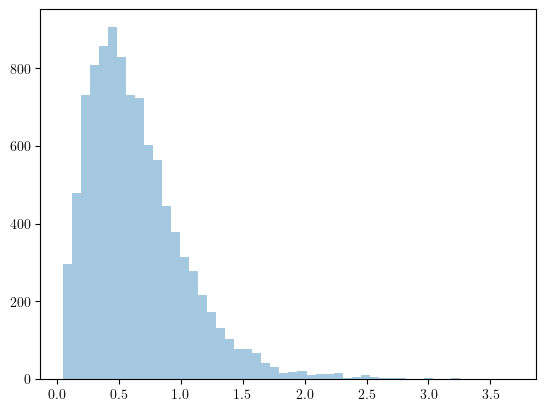

In [12]:
plt.hist(thetaE_all, bins=50, alpha=0.4)

plt.show()

(0.0, 1.5)

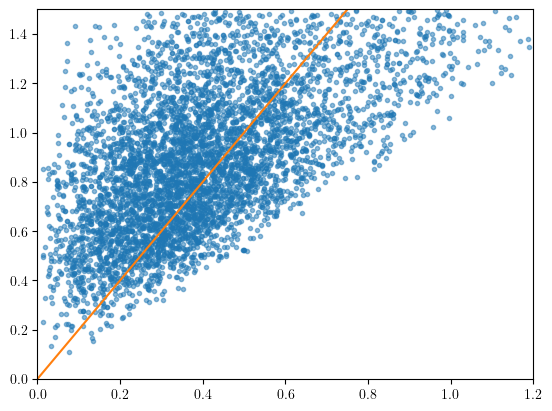

In [31]:
plt.plot(doubles['z_lens'], doubles['z_source'], '.', alpha=0.5)
plt.plot([0, 1.2], [0, 2.4])
plt.xlim(0, 1.2)
plt.ylim(0, 1.5)

In [42]:
sigma_d, sigma_q = [], []

for i in range(len(doubles)):
    sigma_d.append(velocity_dispersion(doubles['z_lens'][i], doubles['z_source'][i], doubles['theta_E'][i]))
    sigma_q.append(velocity_dispersion(quads['z_lens'][i], quads['z_source'][i], quads['theta_E'][i]))
            
sigma_d = np.array(sigma_d)
sigma_q = np.array(sigma_q)

(5000,) (5000,)


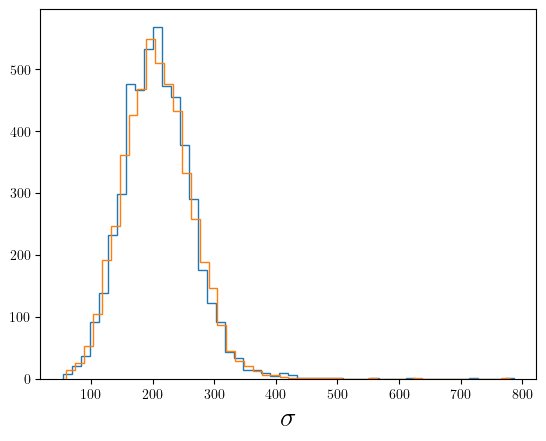

In [74]:
print(np.shape(sigma_d), np.shape(sigma_q))

plt.hist(sigma_d, histtype='step', bins=50)
plt.hist(sigma_q, histtype='step', bins=50)

plt.xlabel(r"$\sigma$", fontsize=20)
plt.show()

In [47]:
sigma_cutoffs = [20, 50, 100, 150, 200]

def sigma_surv_perc(cutoff):
    return len(sigma_d[sigma_d > cutoff]) / len(sigma_d) * 100

for i in range(len(sigma_cutoffs)):
    print("Cutoff ", sigma_cutoffs[i],": ", np.around(sigma_surv_perc(sigma_cutoffs[i]), 2), " remaining")

Cutoff  20 :  100.0  remaining
Cutoff  50 :  100.0  remaining
Cutoff  100 :  98.5  remaining
Cutoff  150 :  86.5  remaining
Cutoff  200 :  54.58  remaining


In [50]:
Mr_d, Mr_q = [], []

def get_Mr(sigma):
    V = np.log10(sigma)
    Mr = (-0.37 + (0.37 ** 2 - (4 * 0.006 * (2.97 + V))) ** 0.5) / (2 * 0.006)
    return Mr

for i in range(len(doubles)):
    
    Mr_d.append(get_Mr(sigma_d[i]))
    Mr_q.append(get_Mr(sigma_q[i]))
    
Mr_d = np.array(Mr_d)
Mr_q = np.array(Mr_q)

(5000,) (5000,)


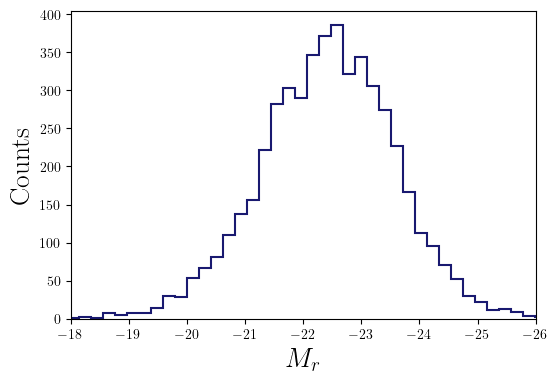

-22.4628220640994


In [69]:
print(np.shape(Mr_d), np.shape(Mr_q))

plt.figure(figsize=(6,4))

plt.hist(Mr_d, histtype='step', bins=50, color='Midnightblue', lw=1.5, label='Lens galaxy')
#plt.hist(Mr_q, histtype='step', bins=50, color='C1', lw=1.5, label='Lens galaxy')
# plt.hist(Mr_q, histtype='step', bins=50)

plt.xlabel(r"$M_r$", fontsize=20)
plt.ylabel(r"Counts", fontsize=20)
plt.xlim(-18, -26)
plt.show()

print(np.nanmedian(Mr_d))

In [160]:
def k_correction(redshift, band):
    """
    Uses the approximate k-correction for elliptical galaxies from Collett (2015)
    https://github.com/tcollett/LensPop
    Interpolates between the (redshift, k-correction) points using scipy.interp1d.

    :param redshift: the input lens redshift for which a k-correction needs to be calculated
    :return: the k-correction for the input redshift
    """

    colours = pd.read_pickle('../data/lenspopsplines.pkl')
    bands = colours[-2]
    z = bands[band +'_SDSS'][0][bands[band +'_SDSS'][1] != 0.0]
    kcor = bands[band +'_SDSS'][1][bands[band +'_SDSS'][1] != 0.0]
    kcorrection = interp1d(z, kcor, bounds_error=False, fill_value='extrapolate')
    return kcorrection(redshift)

def get_m_app(sigma, z_lens, band):
    V = np.log10(sigma)
    Mr = (-0.37 + (0.37 ** 2 - (4 * 0.006 * (2.97 + V))) ** 0.5) / (2 * 0.006)
    
    k_corr = k_correction(z_lens, band)
    m = Mr + cosmo.distmod(z_lens).value - k_corr
    return m

In [163]:
#mi_d, mi_q = [], []
mg_d, mg_q = [], []
mr_d, mr_q = [], []
mi_d, mi_q = [], []
mz_d, mz_q = [], []

for i in range(len(doubles)):
    
    #mi_d.append(get_mi(sigma_d[i], doubles['z_lens'][i], 'i'))
    #mi_q.append(get_mi(sigma_q[i], quads['z_lens'][i], 'i'))
    mg_d.append(get_m_app(sigma_d[i], doubles['z_lens'][i], 'g'))
    mg_q.append(get_m_app(sigma_q[i], quads['z_lens'][i], 'g'))
    mr_d.append(get_m_app(sigma_d[i], doubles['z_lens'][i], 'r'))
    mr_q.append(get_m_app(sigma_q[i], quads['z_lens'][i], 'r'))
    mi_d.append(get_m_app(sigma_d[i], doubles['z_lens'][i], 'i'))
    mi_q.append(get_m_app(sigma_q[i], quads['z_lens'][i], 'i'))
    mz_d.append(get_m_app(sigma_d[i], doubles['z_lens'][i], 'z'))
    mz_q.append(get_m_app(sigma_q[i], quads['z_lens'][i], 'z'))
    
mg_d = np.array(mg_d)
mg_q = np.array(mg_q)
mr_d = np.array(mr_d)
mr_q = np.array(mr_q)
mi_d = np.array(mi_d)
mi_q = np.array(mi_q)
mz_d = np.array(mz_d)
mz_q = np.array(mz_q)

In [126]:
def cutoff(band, threshold):
    if band == 'g':
        bi = 6
    elif band == 'r':
        bi = 7
    elif band == 'i':
        bi = 8
        
    if threshold == 1:
        return max(lenspop[:,bi])

    return np.sort(lenspop[:,bi])[int(threshold * len(lenspop[:,bi]))]

In [159]:
lenspop = np.loadtxt("../data/lenspop_lenses_LSSTa.txt")
#print(len(lenspop[:,6]))
#print(np.sort(lenspop[:,6]))

print("Cut preserving 95% of lens galaxies:")
print("g-band mag: ", cutoff('g', 0.95))
print("r-band mag: ", cutoff('r', 0.95))
print("i-band mag: ", cutoff('i', 0.95))
print(" ")

print("Cut preserving 90% of lens galaxies:")
print("g-band mag: ", cutoff('g', 0.9))
print("r-band mag: ", cutoff('r', 0.9))
print("i-band mag: ", cutoff('i', 0.9))

Cut preserving 95% of lens galaxies:
g-band mag:  25.39
r-band mag:  22.64
i-band mag:  21.36
 
Cut preserving 90% of lens galaxies:
g-band mag:  24.43
r-band mag:  21.93
i-band mag:  20.55


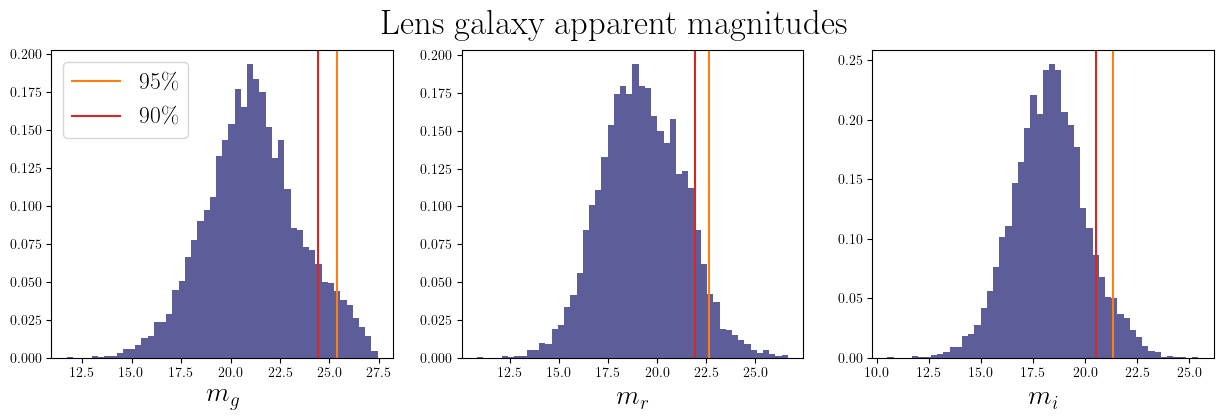

In [158]:
fig, ax = plt.subplots(1, 3, figsize=(15,4))
fig.subplots_adjust(hspace=0.5)
fig.suptitle("Lens galaxy apparent magnitudes", fontsize=25)

ax[0].hist(lenspop[:,6], alpha=0.7, bins=50, lw=1.5, density=True, color='Midnightblue')
ax[0].set_xlabel(r"$m_g$", fontsize=20)
ax[0].axvline(x=cutoff('g', 0.95), color='C1', label=r'$95\%$', lw=1.5)
ax[0].axvline(x=cutoff('g', 0.90), color='C3', label=r'$90\%$', lw=1.5)
ax[0].legend(fontsize=17)

ax[1].hist(lenspop[:,7], alpha=0.7, bins=50, lw=1.5, density=True, color='Midnightblue')
#ax[1].hist(mi_d, histtype='step', bins=50, lw=1.5, label='Scaling rel.', density=True)
ax[1].axvline(x=cutoff('r', 0.95), color='C1', label=r'$95\%$', lw=1.5)
ax[1].axvline(x=cutoff('r', 0.90), color='C3', label=r'$90\%$', lw=1.5)
ax[1].set_xlabel(r"$m_r$", fontsize=20)
#ax[1].legend(fontsize=17)

ax[2].hist(lenspop[:,8], alpha=0.7, bins=50, lw=1.5, density=True, color='Midnightblue')
#ax[2].hist(mi_d, histtype='step', bins=50, lw=1.5, label='Scaling rel.', density=True)
ax[2].axvline(x=cutoff('i', 0.95), color='C1', label=r'$95\%$', lw=1.5)
ax[2].axvline(x=cutoff('i', 0.90), color='C3', label=r'$90\%$', lw=1.5)
ax[2].set_xlabel(r"$m_i$", fontsize=20)
#ax[2].legend(fontsize=17)

# plt.savefig("../Results/Figures/Lens_app_mag_cuts.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')

In [107]:
colours = pd.read_pickle('../data/lenspopsplines.pkl')
bands = colours[-2]
z = bands['i_SDSS'][0][bands['i_SDSS'][1] != 0.0]
kcor = bands['i_SDSS'][1][bands['i_SDSS'][1] != 0.0]

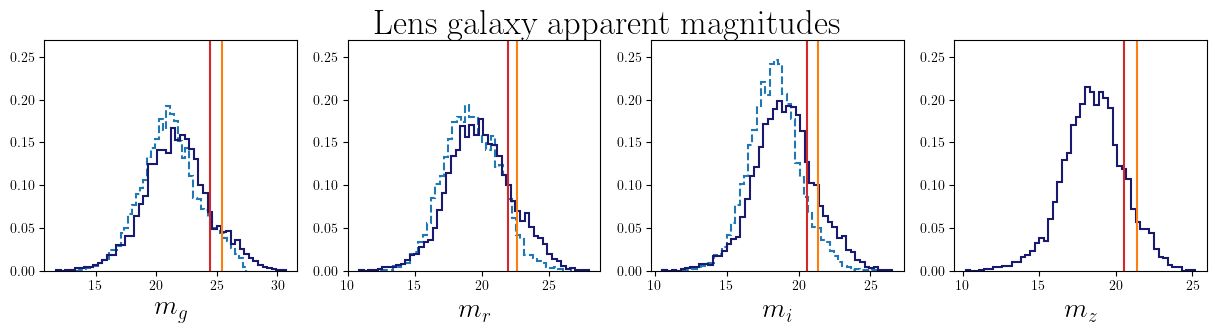

In [177]:
fig, ax = plt.subplots(1, 4, figsize=(15,3))
fig.subplots_adjust(hspace=0.5)
fig.suptitle("Lens galaxy apparent magnitudes", fontsize=25)

ax[0].hist(lenspop[:,6], histtype='step', bins=50, lw=1.5, density=True, ls='--')
ax[0].hist(mg_d, histtype='step', bins=50, lw=1.5, label='Scaling rel.', density=True, color='Midnightblue')
ax[0].set_xlabel(r"$m_g$", fontsize=20)
ax[0].axvline(x=cutoff('g', 0.95), color='C1', label=r'$95\%$', lw=1.5)
ax[0].axvline(x=cutoff('g', 0.90), color='C3', label=r'$90\%$', lw=1.5)
ax[0].set_ylim(0, 0.27)
#ax[0].legend(fontsize=17)

ax[1].hist(lenspop[:,7], histtype='step', bins=50, lw=1.5, density=True, ls='--')
ax[1].hist(mr_d, histtype='step', bins=50, lw=1.5, label='Scaling rel.', density=True, color='Midnightblue')
ax[1].axvline(x=cutoff('r', 0.95), color='C1', label=r'$95\%$', lw=1.5)
ax[1].axvline(x=cutoff('r', 0.90), color='C3', label=r'$90\%$', lw=1.5)
ax[1].set_xlabel(r"$m_r$", fontsize=20)
ax[1].set_ylim(0, 0.27)
#ax[1].legend(fontsize=17)

ax[2].hist(lenspop[:,8], histtype='step', bins=50, lw=1.5, density=True, ls='--')
ax[2].hist(mi_d, histtype='step', bins=50, lw=1.5, label='Scaling rel.', density=True, color='Midnightblue')
ax[2].axvline(x=cutoff('i', 0.95), color='C1', label=r'$95\%$', lw=1.5)
ax[2].axvline(x=cutoff('i', 0.90), color='C3', label=r'$90\%$', lw=1.5)
ax[2].set_xlabel(r"$m_i$", fontsize=20)
ax[2].set_ylim(0, 0.27)
#ax[2].legend(fontsize=17)

ax[3].hist(mz_d, histtype='step', bins=50, lw=1.5, label='Scaling rel.', density=True, color='Midnightblue')
ax[3].axvline(x=cutoff('i', 0.95), color='C1', label=r'$95\%$', lw=1.5)
ax[3].axvline(x=cutoff('i', 0.90), color='C3', label=r'$90\%$', lw=1.5)
ax[3].set_xlabel(r"$m_z$", fontsize=20)
ax[3].set_ylim(0, 0.27)

plt.savefig("../Results/Figures/Lens_app_mag_cuts_griz.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')

In [171]:
def cutoff2(mag_array, threshold):
        
    if threshold == 1:
        return max(mag_array)

    return np.around(np.sort(mag_array)[int(threshold * len(mag_array))], 2)

print("Cut preserving 95% of lens galaxies:")
print("g-band mag: ", cutoff2(mg_d, 0.95))
print("r-band mag: ", cutoff2(mr_d, 0.95))
print("i-band mag: ", cutoff2(mi_d, 0.95))
print("z-band mag: ", cutoff2(mz_d, 0.95))
print(" ")

print("Cut preserving 90% of lens galaxies:")
print("g-band mag: ", cutoff2(mg_d, 0.9))
print("r-band mag: ", cutoff2(mr_d, 0.9))
print("i-band mag: ", cutoff2(mi_d, 0.9))
print("z-band mag: ", cutoff2(mz_d, 0.9))

Cut preserving 95% of lens galaxies:
g-band mag:  26.46
r-band mag:  24.09
i-band mag:  22.77
z-band mag:  21.94
 
Cut preserving 90% of lens galaxies:
g-band mag:  25.29
r-band mag:  23.16
i-band mag:  21.85
z-band mag:  21.07


In [176]:
gr95 = cutoff2(mg_d, 0.95) - cutoff2(mr_d, 0.95)
ri95 = cutoff2(mr_d, 0.95) - cutoff2(mi_d, 0.95)
iz95 = cutoff2(mi_d, 0.95) - cutoff2(mz_d, 0.95)

gr90 = cutoff2(mg_d, 0.9) - cutoff2(mr_d, 0.9)
ri90 = cutoff2(mr_d, 0.9) - cutoff2(mi_d, 0.9)
iz90 = cutoff2(mi_d, 0.9) - cutoff2(mz_d, 0.9)

print("Factors:")
print(" ")
print("95% cut")
print("g-r: ", np.around(gr95, 2))
print("r-i: ", np.around(ri95, 2))
print("i-z: ", np.around(iz95, 2))
print(" ")
print("90% cut")
print("g-r: ", np.around(gr90, 2))
print("r-i: ", np.around(ri90, 2))
print("i-z: ", np.around(iz90, 2))

print(" ")
print("95% cut")
print("g-r: ", np.around(cutoff('g', 0.95) - cutoff('r', 0.95), 2))
print("r-i: ", np.around(cutoff('r', 0.95) - cutoff('i', 0.95), 2))
print(" ")
print("90% cut")
print("g-r: ", np.around(cutoff('g', 0.9) - cutoff('r', 0.9), 2))
print("r-i: ", np.around(cutoff('r', 0.9) - cutoff('i', 0.9), 2))

Factors:
 
95% cut
g-r:  2.37
r-i:  1.32
i-z:  0.83
 
90% cut
g-r:  2.13
r-i:  1.31
i-z:  0.78
 
95% cut
g-r:  2.75
r-i:  1.28
 
90% cut
g-r:  2.5
r-i:  1.38


### Colour cuts

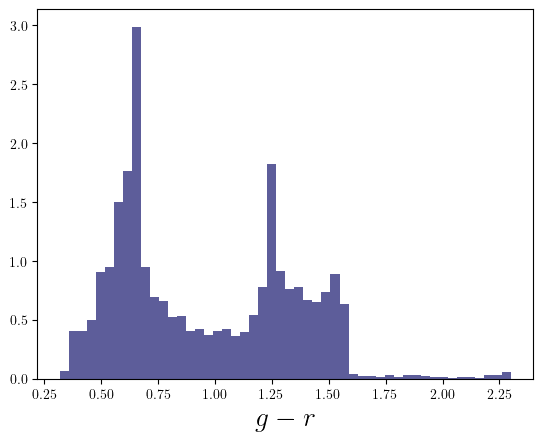

In [186]:
plt.figure()

plt.hist(lenspop[:,7] - lenspop[:,8], color='Midnightblue', alpha=0.7, bins=50, lw=1.5, density=True)
plt.xlabel(r"$g - r$", fontsize=20)
#ax[0].axvline(x=cutoff('g', 0.95), color='C1', label=r'$95\%$', lw=1.5)
#ax[0].axvline(x=cutoff('g', 0.90), color='C3', label=r'$90\%$', lw=1.5)
plt.savefig("../Results/Figures/Lens_gr.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')

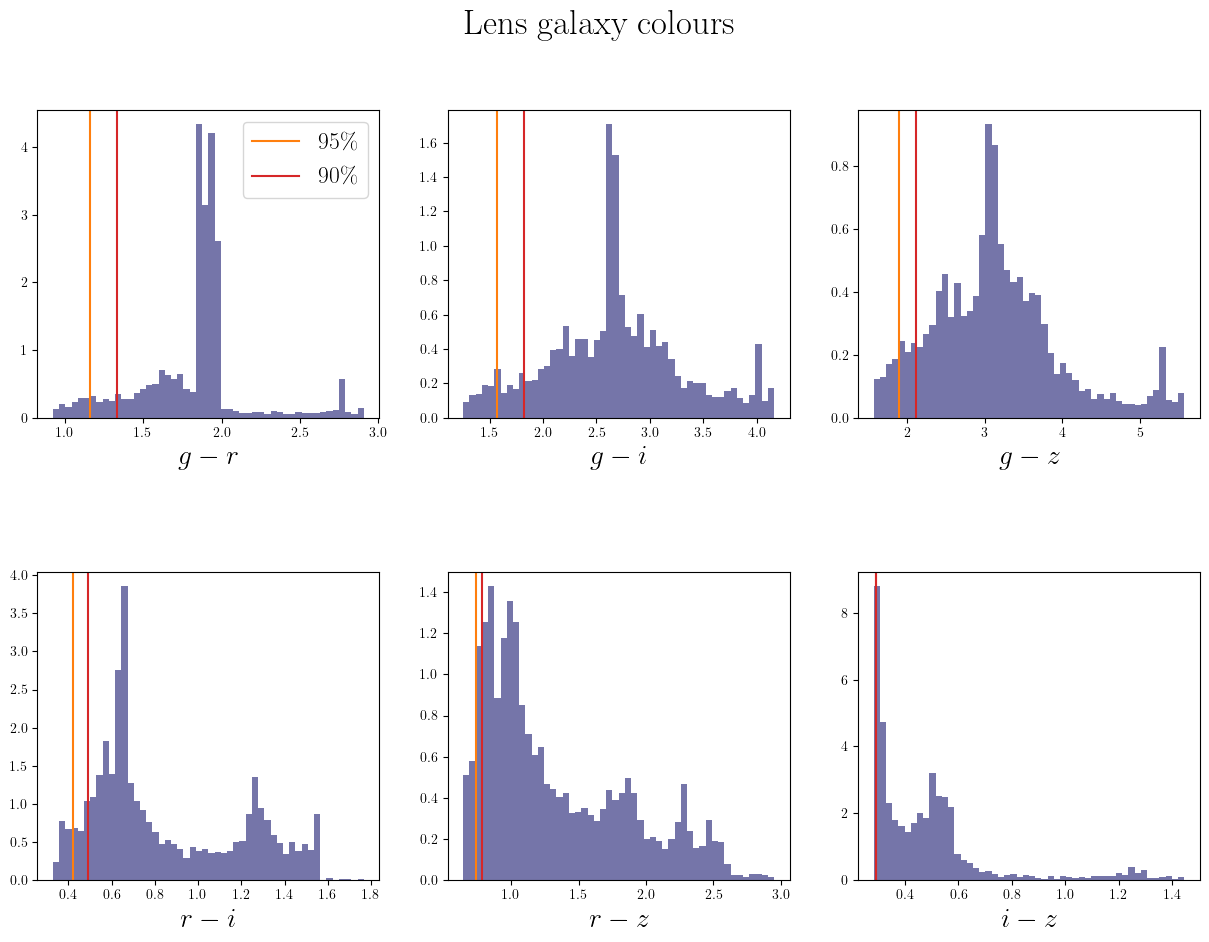

In [196]:
fig, ax = plt.subplots(2, 3, figsize=(15,10))
fig.subplots_adjust(hspace=0.5)
fig.suptitle("Lens galaxy colours", fontsize=25)
ax = ax.flatten()

colours = [mg_d - mr_d, mg_d - mi_d, mg_d - mz_d, mr_d - mi_d, mr_d - mz_d, mi_d - mz_d]
colours_q = [mg_q - mr_q, mg_q - mi_q, mg_q - mz_q, mr_q - mi_q, mr_q - mz_q, mi_q - mz_q]
colours_tom = [lenspop[:,6] - lenspop[:,7], lenspop[:,6] - lenspop[:,8], mg_d - mz_d, lenspop[:,7] - lenspop[:,8], mr_d - mz_d, mi_d - mz_d]
labels = [r"$g - r$", r"$g - i$", r"$g - z$", r"$r - i$", r"$r - z$", r"$i - z$"]

for i in range(len(colours)):
    ax[i].hist(colours[i], color='Midnightblue', alpha=0.6, bins=50, lw=1.5, density=True)
    # ax[i].hist(colours_tom[i], color='C1', alpha=0.4, bins=50, lw=1.5, density=True)
    ax[i].set_xlabel(labels[i], fontsize=20)
    ax[i].axvline(x=cutoff2(colours[i], 0.05), color='C1', label=r'$95\%$', lw=1.5)
    ax[i].axvline(x=cutoff2(colours[i], 0.10), color='C3', label=r'$90\%$', lw=1.5)
    if i == 0:
        ax[i].legend(fontsize=17)

# rplt.savefig("../Results/Figures/Lens_galaxy_all_colours.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')

In [ ]:
    if band == 'g':
        bi = 6
    elif band == 'r':
        bi = 7
    elif band == 'i':
        bi = 8